In [71]:
%load_ext autoreload
%autoreload
from kofscraper import keywords_utils, load_utils, nlp_utils
from kofscraper.config import *
import polars as pl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Embeddings

## Compute

In [2]:
lf = load_utils.load_parquets(CHUNK_DIR + "run_id=2025-11-21/parsed/").slice(0, 100_000)

File ARGUS_chunk_p183.parquet is corrupted


In [3]:
nlp_utils.get_tokens(lf, "text", 1000, "embeddings")

Percent completed: 1.00%, Time remaining: 1:03:18
Percent completed: 2.00%, Time remaining: 0:57:08
Percent completed: 3.00%, Time remaining: 0:51:20
Percent completed: 4.00%, Time remaining: 0:48:56
Percent completed: 5.00%, Time remaining: 0:47:47
Percent completed: 6.00%, Time remaining: 0:46:39
Percent completed: 7.00%, Time remaining: 0:46:00
Percent completed: 8.00%, Time remaining: 0:44:38
Percent completed: 9.00%, Time remaining: 0:43:18
Percent completed: 10.00%, Time remaining: 0:42:02
Percent completed: 11.00%, Time remaining: 0:40:57
Percent completed: 12.00%, Time remaining: 0:41:12
Percent completed: 13.00%, Time remaining: 0:40:34
Percent completed: 14.00%, Time remaining: 0:40:51
Percent completed: 15.00%, Time remaining: 0:40:07
Percent completed: 16.00%, Time remaining: 0:39:52
Percent completed: 17.00%, Time remaining: 0:39:39
Percent completed: 18.00%, Time remaining: 0:38:59
Percent completed: 19.00%, Time remaining: 0:38:17
Percent completed: 20.00%, Time remainin

## Read output
If already computed    

In [4]:
emb = pl.read_parquet(DATA_DIR + "processed/embeddings.parquet").unique()
lf = load_utils.load_parquets(CHUNK_DIR + "run_id=2025-11-21/parsed/").slice(0, 100_000)

emb = emb.join(lf.select("url", 'ID').collect(engine = "streaming"), on = "url").filter(pl.col("url") != "")

File ARGUS_chunk_p183.parquet is corrupted


## Get the similarity to query

### Cosine similarity to keywords

In [23]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

model = SentenceTransformer("all-MiniLM-L6-v2")

kws = load_utils.load_keywords()
#attempt = nlp_utils.get_similarity_to_kws(emb, kws, model)

In [30]:
cat_df = nlp_utils.get_similarity_to_kws(emb, kws, model)

In [35]:
cat_df = nlp_utils.get_categories(cat_df, 0.3)

In [65]:
cat_df = cat_df.filter(~pl.col("predicted").list.contains("unknown")).select("predicted", "url")

The result of matching categories baseod on a cosine similarity of 0.3 or greater to the keywords in a category.
We have 56_609 matches

### Cosine similarity to categories

In [96]:
cat_attempt_without_kws = nlp_utils.get_similarity_to_kws(emb, kws, model)

In [97]:
cat_attempt_no_kws = nlp_utils.get_categories(cat_attempt_without_kws, 0.3)

In [ ]:
cat_attempt_without_kws = cat_attempt_no_kws.filter(~pl.col("predicted").list.contains("unknown")).select("url", "predicted")

By matching the category only we now get 7_669 matches (using the same 0.3 threshold).

### Comparison

In [57]:
urls_no_kws = set(cat_attempt_without_kws.filter(~pl.col("predicted").list.contains("unknown"))["url"])
urls_kws = set(cat_df.filter(~pl.col("predicted").list.contains("unknown"))["url"])
intersection = urls_no_kws.intersection(urls_kws)

print(f"overlap: {len(intersection)} \nintersection / urls category: {(len(intersection) / len(urls_no_kws))*100:.2f} %")

overlap: 6783 
intersection / urls category: 91.26 %


91.26% of companies that are classified as active in some category using the categories are also classified as active using the keywords -> It looks like keywords give us false positives. Confirms kw quality problems

#### Are they the same categories?

In [69]:
comparison = cat_df["url", "predicted"].join(
    cat_attempt_without_kws["url", "predicted"], on = "url", how = "inner", suffix = "_category"
    ).rename({"predicted": "predicted_kw"})

In [86]:
cond_cat = []
cond_kw = []
for cat in kws["category"].to_list():
    value_cat = keywords_utils.find_conditional_probability(
        comparison, conditional_column = "predicted_category", 
        other_column = "predicted_kw",
        category = cat)
    value_kw = keywords_utils.find_conditional_probability(
        comparison, conditional_column = "predicted_kw", 
        other_column = "predicted_category",
        category = cat)
    cond_cat.append(value_cat)
    cond_kw.append(value_kw)

In [87]:
import pandas as pd
print(f"Prob cat_kw | cat_cat: {pd.Series(cond_cat).mean()}, prob cat_cat | cat_kw: {pd.Series(cond_kw).mean()}")

Prob cat_kw | cat_cat: 0.6856028144322213, prob cat_cat | cat_kw: 0.10080293124312396


There is a 68.5% probability that a company is classified as active in a category using keywords given that it was classified using the category name, and only 10% the other way aroud

In [89]:
keywords_utils.add_jaccard(comparison, "predicted_category", "predicted_kw")["jaccard_similarity"].mean()

0.1644843865828745

16.45% Jaccard similarity

## Attempts at stuff
To sort, clean, refactor, delete etc

In [103]:
sim_cols = cat_attempt_without_kws.columns
sim_cols

['url',
 'embeddings',
 'ID',
 'sim_Quantum communication (including quantum key distribution)',
 'sim_Inertial navigation systems',
 'sim_Vaccines and medical countermeasures',
 'sim_Wide and ultrawide bandgap semiconductors',
 'sim_Genomic sequencing and analysis',
 'sim_Novel metamaterials',
 'sim_Small satellites',
 'sim_Atomic clocks',
 'sim_Biofuels',
 'sim_Advanced composite materials',
 'sim_AI algorithms and hardware accelerators',
 'sim_Distributed ledgers',
 'sim_Natural language processing (including speech and text recognition and analysis)',
 'sim_Quantum sensors',
 'sim_Autonomous underwater vehicles',
 'sim_High-specification machining processes',
 'sim_Sonar and acoustic sensors',
 'sim_Drones swarming and collaborative robots',
 'sim_Protective cyber security technologies',
 'sim_Electronic warfare',
 'sim_Multispectral and hyperspectral imaging sensors',
 'sim_Electric batteries',
 'sim_Advanced radiofrequency communication',
 'sim_Continuous flow chemical synthesis'

In [107]:
from sklearn.decomposition import PCA
sim_cols = [c for c in cat_attempt_no_kws.columns if c.startswith("sim_")]
X = cat_attempt_no_kws.select(sim_cols).to_numpy()
pca = PCA(n_components=10)
pca.fit(X)

,n_components,10
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [108]:
pca_output = pca.fit_transform(X)
pca.explained_variance_

array([0.06152802, 0.02868875, 0.02573855, 0.01669789, 0.01227615,
       0.01126955, 0.00952023, 0.00828022, 0.00776418, 0.00708481],
      dtype=float32)

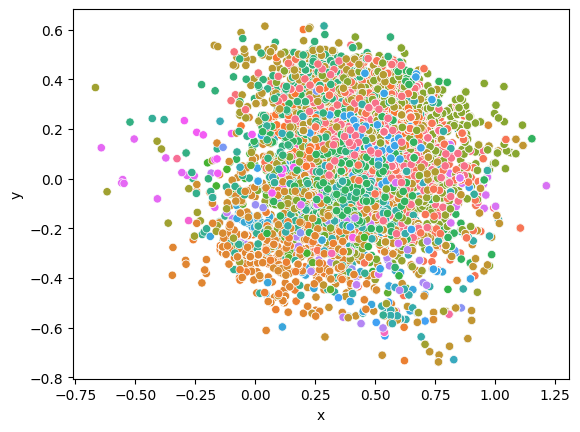

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
xs = [pca_output[i][0] for i in range(len(pca_output))]
ys = [pca_output[i][1] for i in range(len(pca_output))]

plot = pl.DataFrame({"x": xs, "y": ys, "category": cat_attempt_no_kws["predicted"].to_list()}).explode("category")
plot = plot.filter(pl.col("category") != "unknown")

sns.scatterplot(
    x = plot["x"], y = plot["y"], hue= plot["category"]
)
plt.legend([], [], frameon = False)

In [134]:
import umap
reducer = umap.UMAP()

In [157]:
data = pd.DataFrame(cat_attempt_no_kws.filter(~pl.col("predicted").list.contains("unknown")).explode("predicted")[sim_cols])

In [158]:
reducer.fit(data)

/home/msalvetti/notebooks_2/.venv/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


,n_neighbors,15
,n_components,2
,metric,'euclidean'
,metric_kwds,None
,output_metric,'euclidean'
,output_metric_kwds,None
,n_epochs,None
,learning_rate,1.0
,init,'spectral'
,min_dist,0.1
,spread,1.0


In [160]:
embedding = reducer.transform(data)

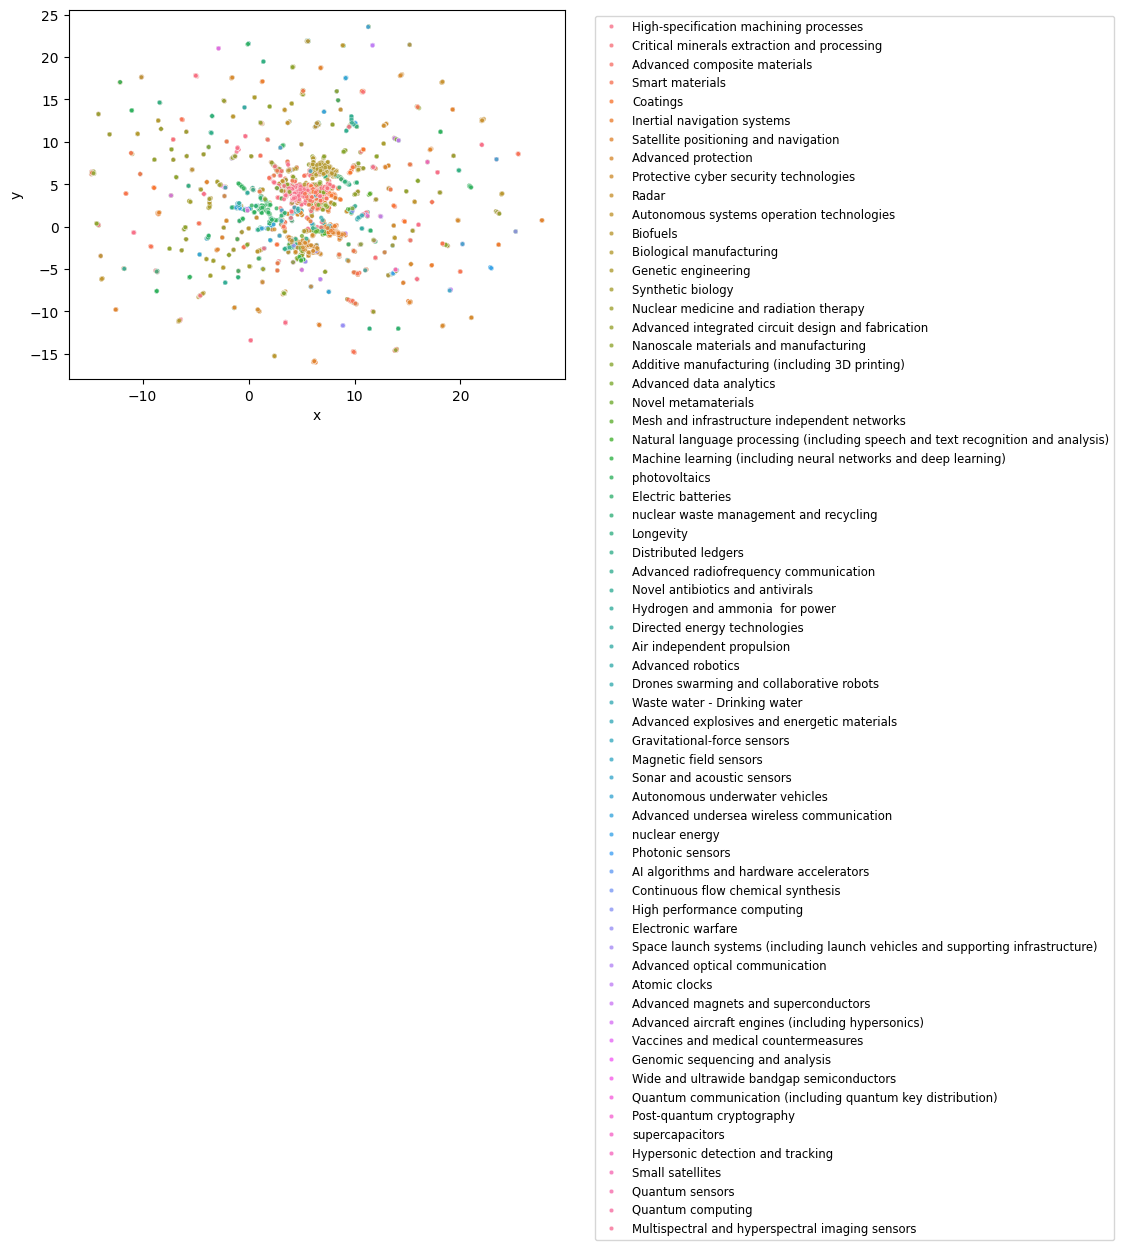

In [175]:
import pandas as pd
labels = colors.to_list()                      # Polars Series -> python list
df = pd.DataFrame({"x": embedding[:,0], "y": embedding[:,1], "label": labels})
sns.scatterplot(data=df, x="x", y="y", hue="label", s=10, alpha=0.8)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize="small")

### Macro categories only

In [179]:
categories = ["Advanced materials and maufacturing",
             "Advanced information and communication technologies",
             "AI technologies",
             "Energy and environment",
             "Quantum",
             "Biotechnology, gene technology and vaccines",
             "sensing, timing and navigation",
             "Defence, space, robotics and transportation"]
macro_cat_df = nlp_utils.get_similarity(emb, categories, model)

In [184]:
macro = nlp_utils.get_categories(macro_cat_df, 0.3).filter(~pl.col("predicted").list.contains("unknown"))

In [185]:
macro

url,embeddings,ID,sim_Advanced materials and maufacturing,sim_Advanced information and communication technologies,sim_AI technologies,sim_Energy and environment,sim_Quantum,"sim_Biotechnology, gene technology and vaccines","sim_sensing, timing and navigation","sim_Defence, space, robotics and transportation",predicted
str,"array[f32, 384]",str,f32,f32,f32,f32,f32,f32,f32,f32,list[str]
"""https://delwest.ch/en/""","[-0.024307, -0.119642, … 0.033197]","""CHCHE108427785""",0.315949,0.225384,0.264663,0.083124,0.118316,0.133895,0.182651,0.15597,"[""Advanced materials and maufacturing""]"
"""https://polyvite.ch/unternehme…","[-0.091032, 0.013482, … -0.060237]","""CHCHE106981289""",0.351461,0.084027,-0.065024,0.050135,-0.014279,-0.039016,-0.101536,0.004989,"[""Advanced materials and maufacturing""]"
"""https://www.itdata.ch/agb/""","[-0.089998, -0.04665, … 0.044573]","""CHCHE109706437""",0.113312,0.313784,0.116137,0.057521,-0.064635,0.084664,0.126642,0.05762,"[""Advanced information and communication technologies""]"
"""https://www.itdata.ch/ueber-un…","[-0.047964, -0.017407, … 0.016878]","""CHCHE109706437""",0.140563,0.362867,0.170849,0.107242,-0.051272,-0.026616,0.272709,0.047564,"[""Advanced information and communication technologies""]"
"""https://www.dach-bachmann.ch/d…","[-0.059041, 0.041281, … 0.045879]","""CHCHE354045063""",0.335032,0.069841,0.005938,0.194197,0.042399,-0.123303,0.029205,0.070026,"[""Advanced materials and maufacturing""]"
…,…,…,…,…,…,…,…,…,…,…,…
"""https://straubgartenbau.ch""","[-0.039345, 0.001788, … -0.03638]","""CHCHE114084765""",0.034418,0.14192,0.041286,0.047067,0.05233,-0.020698,0.306065,0.130341,"[""sensing, timing and navigation""]"
"""https://straubgartenbau.ch/imp…","[-0.005314, -0.053177, … 0.034053]","""CHCHE114084765""",0.158888,0.30114,0.247732,0.10577,-0.03817,0.037832,0.36058,0.230669,"[""Advanced information and communication technologies"", ""sensing, timing and navigation""]"
"""https://straubgartenbau.ch/ges…","[-0.02993, 0.005039, … -0.045598]","""CHCHE114084765""",0.041444,0.090641,0.112061,0.058609,0.014939,-0.001209,0.388385,0.131721,"[""sensing, timing and navigation""]"
